# Pinning checks

In [1]:
import qiskit

from qiskit import QuantumCircuit
from qiskit.transpiler import Layout, PassManager, PassManagerConfig, CouplingMap
from qiskit.transpiler.passes import SetLayout, ApplyLayout
from qiskit import user_config
from qiskit.transpiler.preset_passmanagers.plugin import PassManagerStagePluginManager

from qiskit_ibm_runtime.fake_provider import *

from mod_sabre_swap import SabreSwap

In [2]:
def apply_layout(qc: QuantumCircuit, layout: Layout):
    """Permutes the qubits of the input quantum circuit according to the provided layout"""

    pm = PassManager([SetLayout(layout), ApplyLayout()])

    return pm.run(qc)

def generate_permitted_swaps(coupling_map: CouplingMap, pinned_qubits=None):
    if pinned_qubits is None:
        return coupling_map

    qubits = coupling_map.physical_qubits
    edges = coupling_map.get_edges()
    edges = ((src, dst) for src, dst in edges if src not in pinned_qubits)
    edges = ((src, dst) for src, dst in edges if dst not in pinned_qubits)

    coupling_map = CouplingMap()
    for qubit in qubits:
        coupling_map.add_physical_qubit(qubit)
    for src, dst in edges:
        coupling_map.add_edge(src, dst)

    return coupling_map

def pinned_routing(qc: QuantumCircuit, coupling_map: CouplingMap, pinned_qubits=None):
    permitted_swaps = generate_permitted_swaps(coupling_map, pinned_qubits)
    sabre_swap = SabreSwap(coupling_map=coupling_map, permitted_swaps=permitted_swaps)
    pm = PassManager(sabre_swap)

    return pm.run(qc)


plugin_manager = PassManagerStagePluginManager()


def translate_and_optimize(qc: QuantumCircuit, basis_gates, optimization_level=None, seed=None):
    if optimization_level is None:
        config = user_config.get_config()
        optimization_level = config.get("transpile_optimization_level", 3)
    else:
        optimization_level = optimization_level

    config = PassManagerConfig(
        basis_gates=basis_gates,
        optimization_method="default",
        seed_transpiler=seed,
    )
    optimization_pass = plugin_manager.get_passmanager_stage(
        "optimization",
        "default",
        config,
        optimization_level=optimization_level,
    )

    return optimization_pass.run(qc)


def magic(
    qc: QuantumCircuit,
    layout: Layout,
    coupling_map: CouplingMap,
    basis_gates=None,
    pinned_qubits=None,
    optimization_level=None,
    seed=None,
):
    if optimization_level is None:
        config = user_config.get_config()
        optimization_level = config.get("transpile_optimization_level", 3)
    else:
        optimization_level = optimization_level

    permitted_swaps = generate_permitted_swaps(coupling_map, pinned_qubits)

    config = PassManagerConfig(
        basis_gates=basis_gates,
        optimization_method="default",
        seed_transpiler=seed,
    )
    optimization_pass = plugin_manager.get_passmanager_stage(
        "optimization",
        "default",
        config,
        optimization_level=optimization_level,
    )

    pm = PassManager(
        [
            SetLayout(layout),
            ApplyLayout(),
            SabreSwap(coupling_map=coupling_map, permitted_swaps=permitted_swaps),
            optimization_pass.to_flow_controller(),
        ]
    )

    return pm.run(qc)

### Create example circuit: Toffoli with three controls

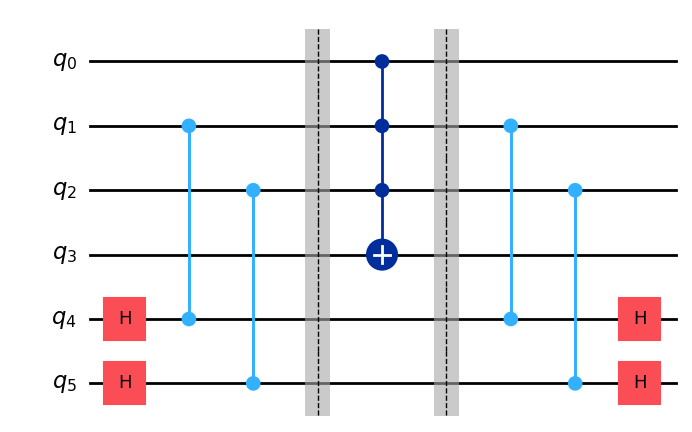

In [3]:
qc_1 = QuantumCircuit(6)

qc_1.h(4)
qc_1.cz(4, 1)
qc_1.h(5)
qc_1.cz(5, 2)
qc_1.barrier()
qc_1.mcx([0, 1, 2], 3)
qc_1.barrier()
qc_1.cz(4, 1)
qc_1.h(4)
qc_1.cz(5, 2)
qc_1.h(5)
qc_1.draw("mpl",fold=-1)

### Create a layout and pin qubits

In [4]:
coupling_map = [
    [0, 1],
    [1, 0],
    [1, 2],
    [2, 1],
    [2, 3],
    [3, 2],
    [3, 4],
    [4, 3],
    [4, 5],
    [5, 4],
]
coupling_map = CouplingMap(coupling_map)

basis_gates = ["rz", "sx", "x", "cx"]
layout = [2, 1, 4, 3, 0, 5]  # {q_reg[0]:0, q_reg[2]:1}
layout = Layout.from_intlist(layout, *qc_1.qregs)

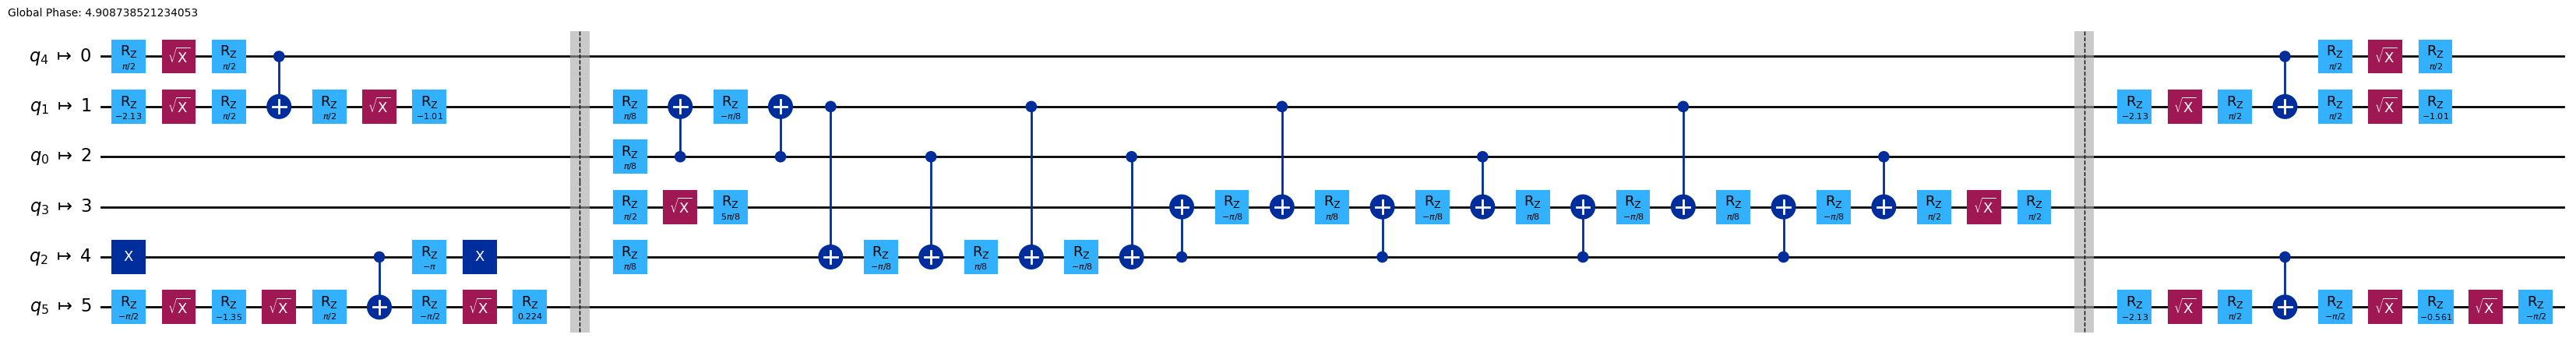

In [5]:
qc_magic = magic(
    qc_1,
    layout,
    coupling_map,
    basis_gates,
    pinned_qubits=[0, 5],
    optimization_level=3,
    seed=None,
)
qc_magic.draw("mpl",fold=-1)

### Pin qubits on Fake Backend

In [6]:
fake_backend = FakeWashingtonV2()

In [7]:
fake_backend.num_qubits

127

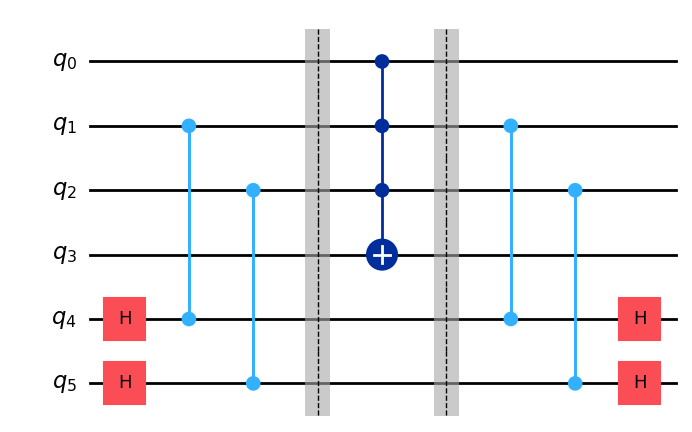

In [8]:
qc_1 = QuantumCircuit(127)

qc_1.h(4)
qc_1.cz(4, 1)
qc_1.h(5)
qc_1.cz(5, 2)
qc_1.barrier()
qc_1.mcx([0, 1, 2], 3)
qc_1.barrier()
qc_1.cz(4, 1)
qc_1.h(4)
qc_1.cz(5, 2)
qc_1.h(5)
qc_1.draw("mpl",fold=-1, idle_wires=False)

In [9]:
# need helper for this. circuit qubits must match layout and coupliing map
# todo: inform initial layout using Mapomatic
layout_fake_backend = [2, 1, 4, 3, 0, 5] + list(range(6,127)) 

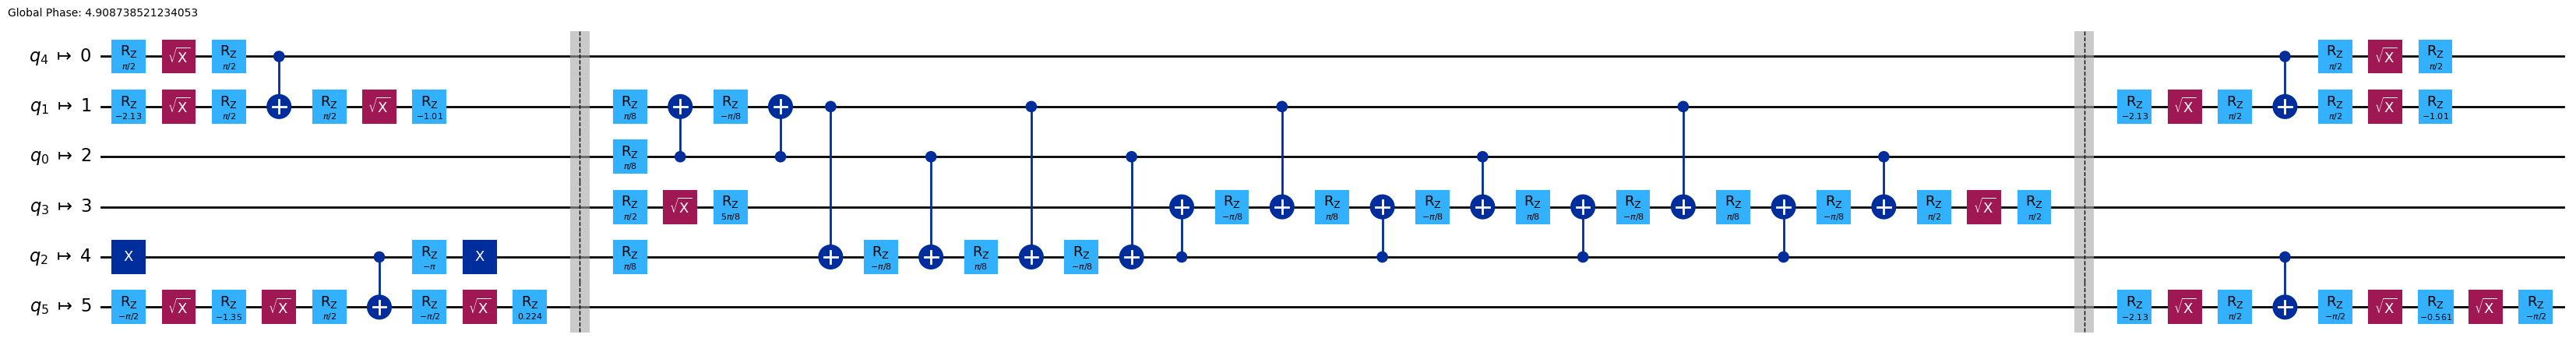

In [10]:
qc_magic_fake_backend = magic(qc_1,
                              layout_fake_backend,
                              fake_backend.coupling_map,
                              fake_backend.configuration().basis_gates,
                              pinned_qubits=[0, 5],
                              optimization_level=3,
                              seed=None,
                              )
qc_magic.draw("mpl",fold=-1,idle_wires=False)